# Demo: Spectral Differentiation (Periodic Case)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

from numpy.fft import fft, ifft
from scipy import sparse

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
# Update 07/18/22: got retina working with updates thanks to 
# https://stackoverflow.com/questions/54312924/what-is-matplotlibs-retina-display-mode
%matplotlib inline
%config InlineBackend.figure_format='retina'

In this demo we investigate spectral differentiation, a very useful alternative to finite difference approximations valid for functions defined on periodic grids. Note that there is also a version of spectral differentiation valid for *non-periodic* grids, but we will investigate this method in a later demo (it involves Chebyshev polynomials!). 

## Background & Motivation

Recall that any complex-valued, square-integrable function $u(x)$ on the unit circle $S^1$ (equivalently, the closed interval $[-\pi,\pi]$ with endpoints identified) admits a **Fourier series** expansion in the form 
$$ u(x) = \sum_{k\in \mathbb{Z}} \hat{u}_{k} e^{ikx},$$
where the **Fourier coefficients** $\hat{u}_{k}$ obey
$$ \hat{u}_{k} = \frac{1}{2\pi} \int_{-\pi}^{\pi} e^{-ikx} \  u(x) \ \mathrm{d}x. $$ 
The convergence of the Fourier series is understood in an $L^2$ sense, but if $u(x)\in C^1\left(S^1\right)$ then we can actually upgrade to uniform convergence, see for example Courant & Hilbert volume 1. In the language of abstract harmonic analysis, the function-to-coefficients map 
$$
u(x)\in L^2\left(S^1\right) \mapsto \left\{\hat{u}_{k}\right\}_{k\in \mathbb{Z}}\in \ell_{2}\left(\mathbb{Z}\right)
$$
is called the **Fourier transform on $S^1$**. 

Now, if $u(x)\in C^1\left(S^1\right)$, then the Fourier coefficients of $\partial_{x}u(x)$ can be computed using only the Fourier coefficients of $u(x)$ via the formula 
$$ \widehat{\partial_{x}u}_{k} = ik \hat{u}_{k}. $$
This is a one-life proof using integration by parts. The above formula suggests a recipe for computing derivatives numerically: if we can approximate sufficiently many of the Fourier coefficients of $u(x)$ reasonably quickly, then we just multiply these approximations by their corresponding $k$ to get guesses of the Fourier coefficients of $\partial_{x}u$. From there, we use these coefficient guess to write an approximation of $\partial_{x}u$ as a truncated Fourier series. Functions that are very smooth on $S^1$ are approximated unbelievably well by truncations of their Fourier series, so naively the approximation procedure we've just sketched should work reasonably well. Of course, this is just intuition, and to sharpen this intuition we need a few more definitions. 

## Details of Spectral Differentiation via the Discrete Fourier Transform

We turn next to formulating the derivative-approximating method described above more precisely. The resulting method is called **spectral differentiation**. We start with a discretization of the interval $[-\pi,\pi)$ into $N=2^{n}\in \mathbb{N}$ grid points: 
$$ -\pi = x_0 < x_{1} < \cdots <x_{N-2} < x_{N-1} < \pi. $$
We use the Python 'index zero comes first' convention here. Note also that we ignore the right endpoint $\pi$ in our grid because we're assuming endpoints are identified. Additionally, we assume that our grid is uniformly spaced: for all $j=1,...,N-1$, 
$$ x_{j}-x_{j-1} = h \doteq \frac{2\pi}{N}. $$
Said differently, we are approximating the circle $S^1$ by the $N^{\text{th}}$ roots of unity, the set of all which constitutes an abelian group that is isomorphic to $\mathbb{Z}_{N}=\mathbb{Z}/N\mathbb{Z}$. To describe spectral differentiation precisely, we then need to first develop a **Fourier transform on $\mathbb{Z}_{N}$**, also called the **discrete Fourier transform**. 

The correct definition of such a Fourier transform is obvious: instead of Fourier-transforming a function $u(x)$ defined on $S^1$, we Fourier-transform *samples* of $u(x)$ at the lattice sites (or, if we're comfortable abusing notation, $u(x)$ restricted to $\mathbb{Z}_{N}$), denoted $u_{\ell}=u(x_{\ell})$. By simply estimating the Fourier coefficients of $u(x)$ via the midpoint rule (assuming $u(x)$ is piecewise-constant on grid cells), we get 
$$
\hat{u}_{k} \approx h \sum_{\ell=0}^{N-1} e^{-ikx_{\ell}} u_{\ell}. 
$$
We can then *define* the right-hand side of the above to be $h$ times the discrete Fourier transform of the array of samples $\left\{u_{\ell}\right\}_{\ell=0}^{N-1}.$ What values can $k\in \mathbb{Z}$ take? Notice that two functions on our lattice of the form
$$ e^{-ik_{1}x_{\ell}}, \   e^{-ik_{2}x_{\ell}}$$ 
are indistinguishable if $k_{1} = k_{2}$ mod $N$ . For example, if $k_{2}=k_{1}+N$, then since $x_{\ell}= \frac{2\pi}{N}\ell$ we have
$$ e^{-ik_{2}x_{\ell}} = e^{-2\pi i \ell}e^{-ik_{1}x_{\ell}} = e^{-ik_{1}x_{\ell}}.$$
Therefore, to avoid redundancies, we should only take $k$ from a specified range that involves no "repeats" mod $N$. In other words, the set of admissible $k$'s is also a copy of $\mathbb{Z}_{N}$. In signal processing language, the indistinguishability of certain functions of the form $e^{-ikx_{\ell}}$, with $x_{\ell}$ belonging to a finite lattice, is called **aliasing**. 

With all this in mind, we have that our discrete Fourier transform (DFT) is a mapping
$$ \left\{u_{\ell}\right\}_{\ell}\in \ell^2\left(\mathbb{Z}_{N}\right) \mapsto \left\{\hat{u}_{k}\right\}_{k}\in \ell^2\left(\mathbb{Z}_{N}\right)$$
given explicitly by 
$$ \hat{u}_{k} = \sum_{\ell=0}^{N-1} e^{-ikx_{\ell}} u_{\ell}. $$
Since we deal exclusively with the DFT rather than Fourier series below, there will be no confusion with the hat notation doing double-duty. Note that the Fourier transform is invertible, with inverse given explicitly by the IDFT
$$
{v}_{\ell}^{\vee} = \frac{h}{2\pi} \sum_{k=0}^{N-1}e^{ikx_{\ell}} v_{k}. 
$$
TODO: type up the proof. 
After sampling our function of choice $u(x)$, the corresponding DFT can be computed efficiently using the fast Fourier transform (FFT), which is available in easy-to-use numpy and scipy implementations. The FFT turns out to work best when $N$ is a power of two, as we have assumed here. Additionally, the IDFT can be computed with the inverse analogue of the FFT, called the IFFT (where the meaning of the "I" should be obvious). Note that the conventions for normalizing the DFT and IDFT presented here agree with the numpy and scipy FFT implementations, but disagree with that used in Trefethen's book on spectral methods (Trefethen 2000). 

One can show (TODO: type up the proof) that, if $D_{h}$ denotes the forward finite difference operator acting on lattice samples, then
$$ \widehat{D_{h}u}_{k} = ik\hat{u}_{k} + \mathcal{O}\left(h\right),$$
where the bounding constant depends on $\max_{\ell}\left|u_{\ell}\right|$. So, for $h$ sufficiently small, we can indeed recover approximations of the Fourier coefficients of $\partial_{x} u$ by applying the FFT to samples $u_{\ell}$, multiplying those samples by an easily-assembled fixed vector, and then appyling the inverse FFT. In other words, spectral differentiation takes the form 
$$ \partial_{x}u(x_{\ell}) \approx \mathrm{IFFT}\left(ik \ \mathrm{FFT}(\left\{u_{\ell}\right\}_{\ell}))\right)[\ell]. $$
The reader should take a moment and sketch this numerical method out visually in the form of an (approximately) commuting diagram. Again emphasizing that we are allowed to take the FFT and IFFT for granted when using numpy, spectral differentiation is going to be trivial to implement! The hardest part turns out to be remembering to initialize our arrays as containing complex entries (due to Python conventions). In looking at numerical examples of spectral differentiation, we shall also see an accuracy improvement over finite differencing, the significance of which is hard to overstate. 

TODO: insert some discussion on the theoretical aspects of spectral differentiation convergence/spectral accuracy, cf. Trefethen 2000 chapter 4. 

TODO: some discussion on abstract harmonic analysis? cf. Kenny's 1995 survey paper

## Numerical Examples

Let's look at a head-to-head fight between forward finite differences and spectral differentation. First, choose the particular example function you want to deal with via the $\texttt{option}$ keyword. 

- $\texttt{option = 'C1'}$ produces the function
$$ u(x) = e^{-x^2}\sin(x), $$
which is $C^1$ but not $C^2$ on $S^1$; 
- $\texttt{option = 'smooth'}$ produces the function 
$$ u(x) = e^{-6\cos^2(x)}\sin(x), $$
which is smooth on $S^1$. 

TODO: add an option for fncs that are not even $C^1$, after Trefethen 2000, p. 36. Try even more exotic options! 

In [2]:
option = 'C1'  # can be chosen as 'C1' or 'smooth'

def test_fnc(x):
    
    if option == 'C1':
    
        out = np.exp(-x**2)*np.sin(x)
        
    elif option == 'smooth':
        
        out = np.exp(-6.*(np.cos(x))**2)*np.sin(x)
    
    return out

def test_fnc_prime(x):
    
    if option == 'C1':
    
        out = -2.*x*test_fnc(x) + np.exp(-x**2)*np.cos(x)
        
    elif option == 'smooth':
        
        out = 12.*np.cos(x)*np.sin(x)*test_fnc(x)+np.exp(-6.*(np.cos(x))**2)*np.cos(x)
        
    return out 

Then, we build a function to create the forward finite difference matrix corresponding to a periodic mesh of a given size. 

In [3]:
def D_forward_matrix(N):
    
    D = sparse.diags([-1.*np.ones(N),np.ones(N-1)], [0,1], shape=(N,N)).toarray()
    
    D[-1,0] = 1. # using periodicity of the grid

    # Strictly speaking we should represent D as a sparse matrix for optimal performance.
    # But, the purpose of this demo is to analyze the accuracy, not speed, of 
    # numerical differentiation. 
    
    return (N/(2.*np.pi))*D #note: meant to act on COLUMN vectors

Using this function, we can create a routine that takes in an array of a given size (viewed as samples of a scalar function on $S^1$, stored in a column vector) and returns estimates of the derivative of that function. 

In [4]:
def forward_fd(u):
    
    N = np.shape(u)[0]
    
    u_new = u.reshape((N,)) # change to a column vector just in case
    
    D = D_forward_matrix(N)
    
    ux = np.matmul(D,u_new)
        
    return ux.reshape((N,))

Next, we implement spectral differentiation. The function below takes in samples of a function $u(x)$ on our periodic grid, still stored as a column vector, and returns the estimates of $u_{x}(x)$ at the grid points obtained by spectral differentiation. 

In [5]:
def spec_deriv(u):
    
    N = np.shape(u)[0]
    
    h = 2.*np.pi/N
    
    u_new = u.reshape((N,)) # change to a column vector just in case
    
    u_hat = fft(u_new)
    
    # get symbol of partial_x = ik
    partialx = 1j*np.zeros(N)
    partialx[0:int(N/2)] = 1j*np.arange(0,int(N/2))
    partialx[int(N/2)+1:] = 1j*np.arange(-int(N/2)+1,0,1) # this line = ik
    
    ux = ifft(partialx*u_hat)
        
    return ux.reshape((N,))

Now, we compare the performance of both the forward finite difference method and the spectral method for computing $u_{x}\left(\frac{\pi}{2}\right)$, where $u(x)$ is the function you chose at the start of the demo. There is nothing special about the point $\pi/2$, except that it is easy to figure out what lattice site index it corresponds to. 

In [6]:
grid_n = np.arange(2,12)

errors_fd = np.ones_like(grid_n, dtype=float)

errors_spec = np.ones_like(grid_n, dtype=float)

ux_exact = test_fnc_prime(np.pi*0.5)

for n in np.arange(0,np.size(grid_n)): 
    
    N = 2**grid_n[n]

    xx = np.linspace(-np.pi,np.pi,N, endpoint = False) 
    # endpoint flag makes sure we avoid the last endpoint
        
    u = test_fnc(xx)
        
    fd_estimate = forward_fd(u)[-2**(n)]
    
    spec_estimate = spec_deriv(u)[-2**(n)]
        
    errors_fd[n] = np.abs(ux_exact-fd_estimate)
        
    errors_spec[n] = np.abs(ux_exact-spec_estimate)
    
    # notice that, with our gridsize being 2^n, pi/2 is always a lattice point for n>1. 
    # The backward index # of this point is 2^n as well, by some simple pen-and-paper reasoning
    # (draw the lattices out for various n!)

We plot the log-error in both approximations as a function of grid size $N$: 

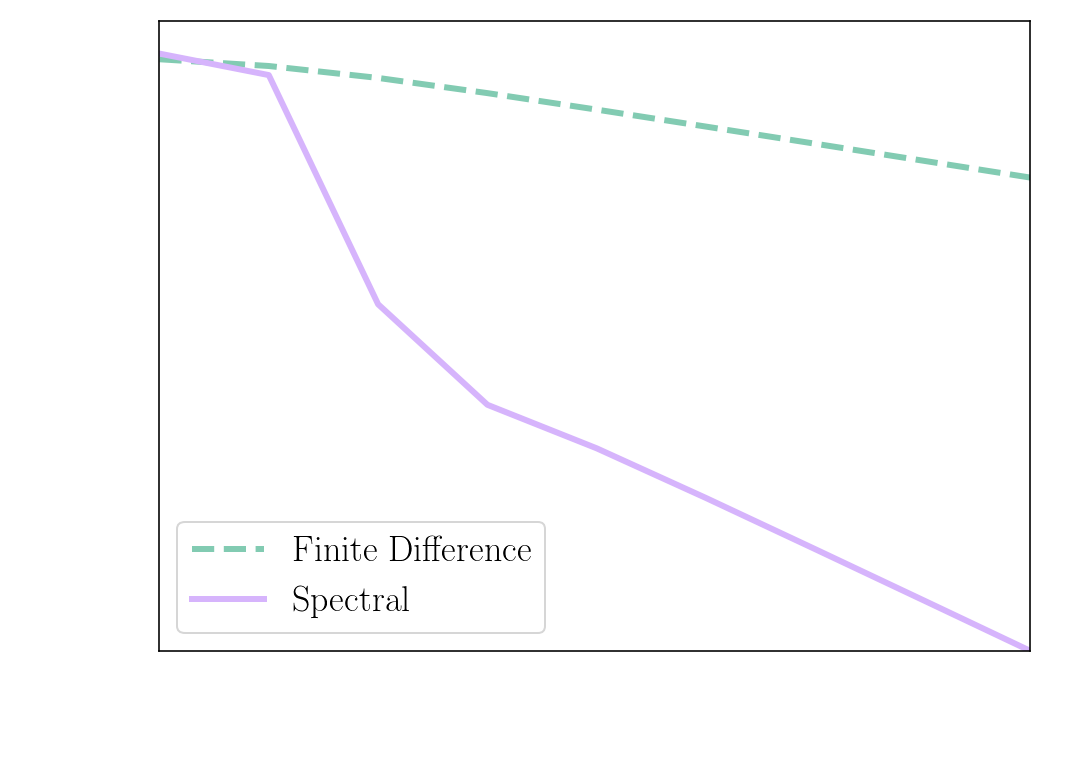

In [14]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
        
plt.loglog(2**grid_n, errors_fd, color='xkcd:pale teal', linewidth='3', linestyle='dashed', label=r"Finite Difference")

plt.loglog(2**grid_n, errors_spec, color='xkcd:light violet', linewidth='3', linestyle='solid',label=r"Spectral")

plt.xlim([4,1e3])
plt.ylim([1e-11,1e0])

ax.legend(fontsize=18, loc='best')

plt.xlabel(r"$\log_{2}\left(N\right)$", fontsize=26, color = 'w')
plt.ylabel(r"Error", fontsize=26, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=18, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=18, rotation=0, color = 'w')
#ax.locator_params(axis='y', nbins=6)
#ax.locator_params(axis='x', nbins=6)

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600
    
plt.show()

The plot you see above looks different depending on the $\texttt{option}$ keyword you selected: 
- $\texttt{option = 'C1'}$ : the spectral method essentially always produces a much better approximation than the finite difference method. Also, the error for the spectral method decreases much more quickly than the error for the finite difference method, which we recall is approximately linear in $N^{-1}$. It is worth pointing out that, even for $N=2048$, we do not quite achieve machine precision with the spectral scheme. 
- $\texttt{option = 'smooth'}$: here, the spectral method beats the finite difference method by an even wider margin: even for extremely coarse meshes, the spectral scheme is very close to machine-accurate. 

Thus, the points you should take home are that spectral differentiation is amazingly more accurate than finite differencing. Further, the smoother the function on $S^1$ we want to differentiate, the faster spectral differentiation produces a machine-accurate answer.  